In [49]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [50]:
dataset = pd.read_csv('data.csv')
# Parse strings to datetime type
dataset['Date'] = pd.to_datetime(dataset['Date'], infer_datetime_format = True)
indexedDataset = dataset.set_index(['Date'])

In [51]:
from datetime import datetime
indexedDataset.head()

,Radiance
Date,
2014-01-01,0.761
2014-02-01,0.859
2014-03-01,0.884
2014-04-01,0.981
2014-05-01,0.842


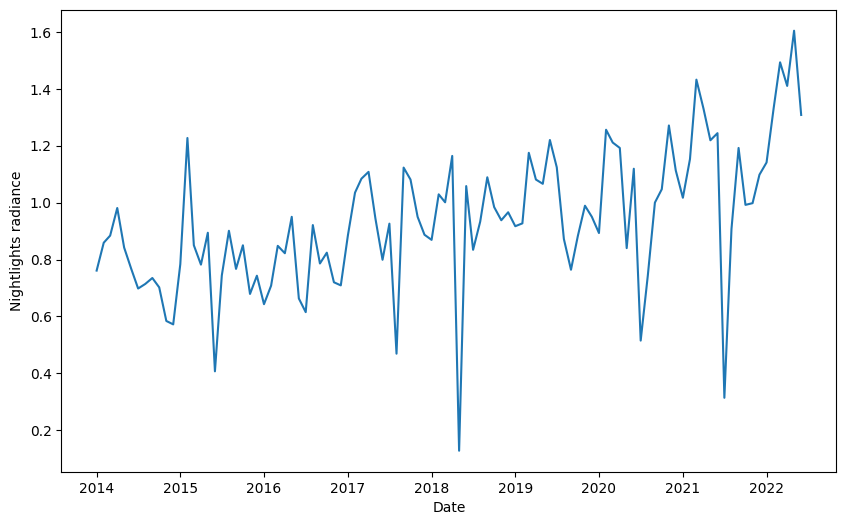

In [52]:
# plot graph

plt.xlabel('Date')
plt.ylabel('Nightlights radiance')
plt.plot(indexedDataset)

In [53]:
# Determining rolling statistics
rolmean = indexedDataset.rolling(window = 12).mean()
rolstd = indexedDataset.rolling(window = 12).std()
print(rolmean, rolstd)

            Radiance
Date                
2014-01-01       NaN
2014-02-01       NaN
2014-03-01       NaN
2014-04-01       NaN
2014-05-01       NaN
...              ...
2022-02-01  1.099917
2022-03-01  1.105000
2022-04-01  1.111667
2022-05-01  1.143750
2022-06-01  1.149083

[102 rows x 1 columns]             Radiance
Date                
2014-01-01       NaN
2014-02-01       NaN
2014-03-01       NaN
2014-04-01       NaN
2014-05-01       NaN
...              ...
2022-02-01  0.292187
2022-03-01  0.298942
2022-04-01  0.305242
2022-05-01  0.336211
2022-06-01  0.338446

[102 rows x 1 columns]


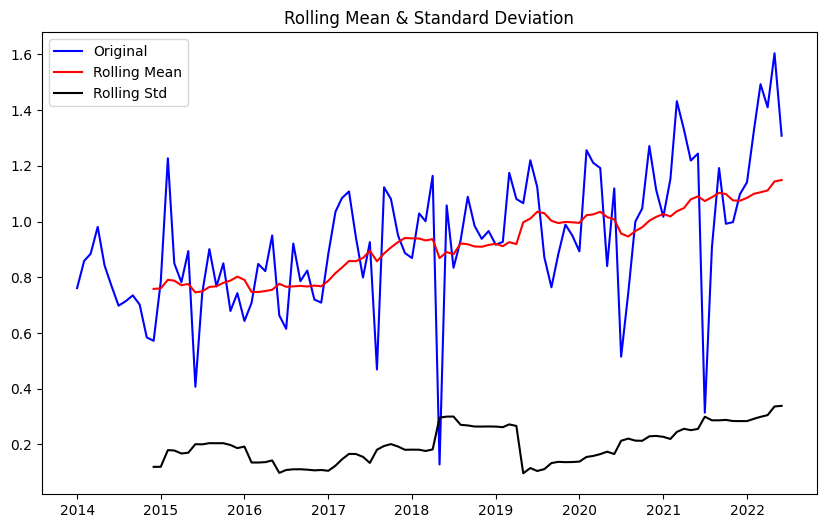

In [54]:
# Plot rolling statistics

orig = plt.plot(indexedDataset, color = 'blue', label = 'Original')
mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [55]:
# Perform Dickey-Fuller Test

from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test:')
dftest = adfuller(indexedDataset['Radiance'], autolag = 'AIC')

dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value

print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -0.066351
p-value                         0.952689
#Lags Used                     11.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


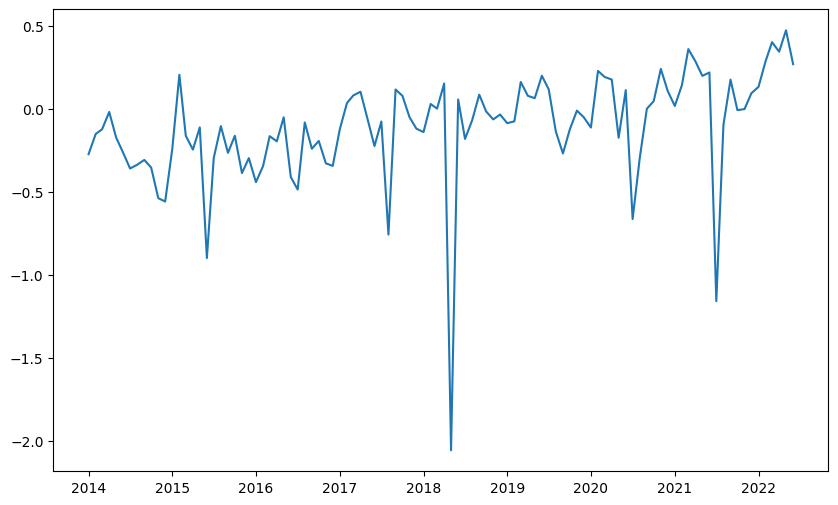

In [56]:
# Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)


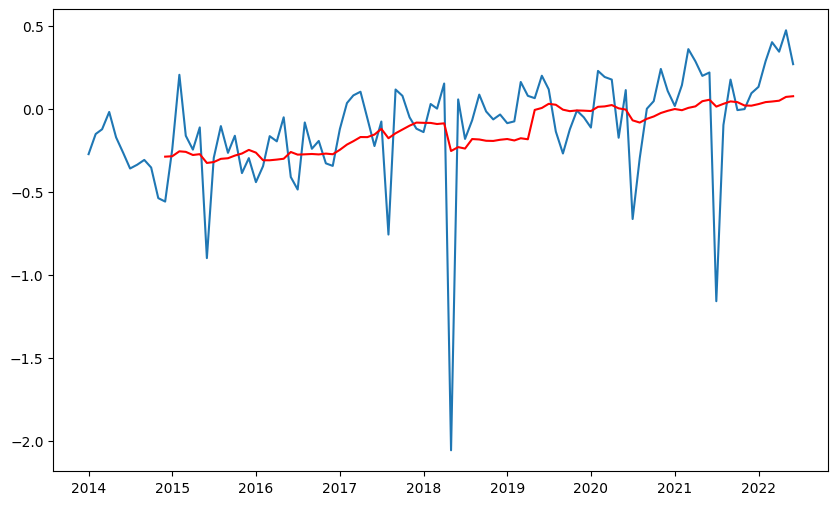

In [57]:
movingAverage = indexedDataset_logScale.rolling(window = 12).mean()
movingStd = indexedDataset_logScale.rolling(window = 12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color = 'red')

In [58]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#remove Nan values
datasetLogScaleMinusMovingAverage.dropna(inplace = True)
datasetLogScaleMinusMovingAverage.head(10)

,Radiance
Date,
2014-12-01,-0.270331
2015-01-01,0.042457
2015-02-01,0.460663
2015-03-01,0.096840
2015-04-01,0.032351
2015-05-01,0.161209
2015-06-01,-0.572878
2015-07-01,0.025032
2015-08-01,0.197111


In [59]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    # Determining rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()

    # Plot rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller Test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Radiance'], autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)


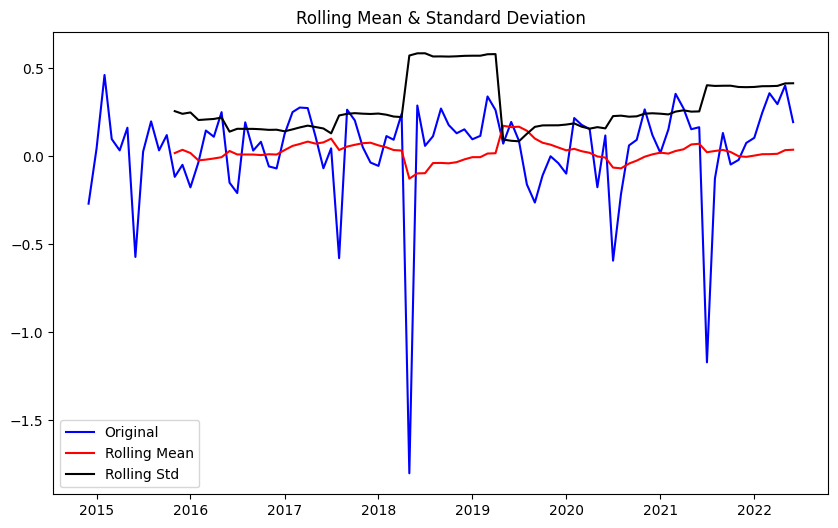

Results of Dickey-Fuller Test:
Test Statistic                -9.311213e+00
p-value                        1.047837e-15
#Lags Used                     0.000000e+00
Number of Observations Used    9.000000e+01
Critical Value (1%)           -3.505190e+00
Critical Value (5%)           -2.894232e+00
Critical Value (10%)          -2.584210e+00
dtype: float64


In [60]:
test_stationarity(datasetLogScaleMinusMovingAverage)

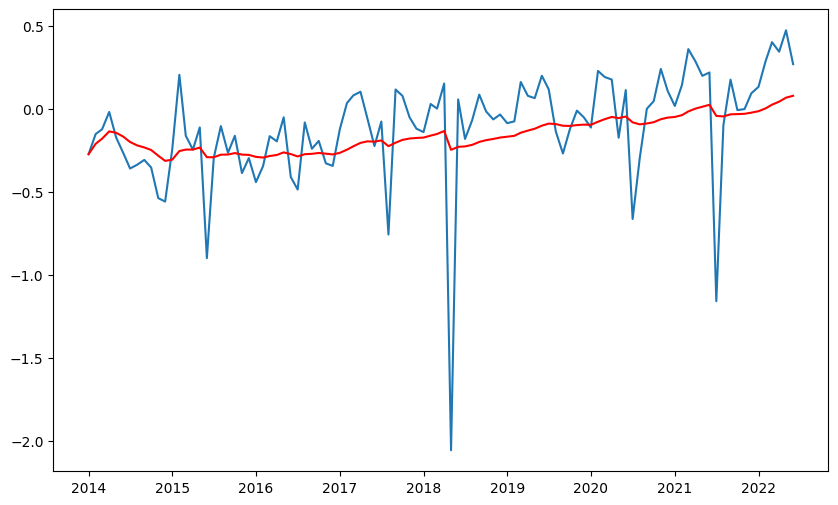

In [61]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife = 12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color = 'red')

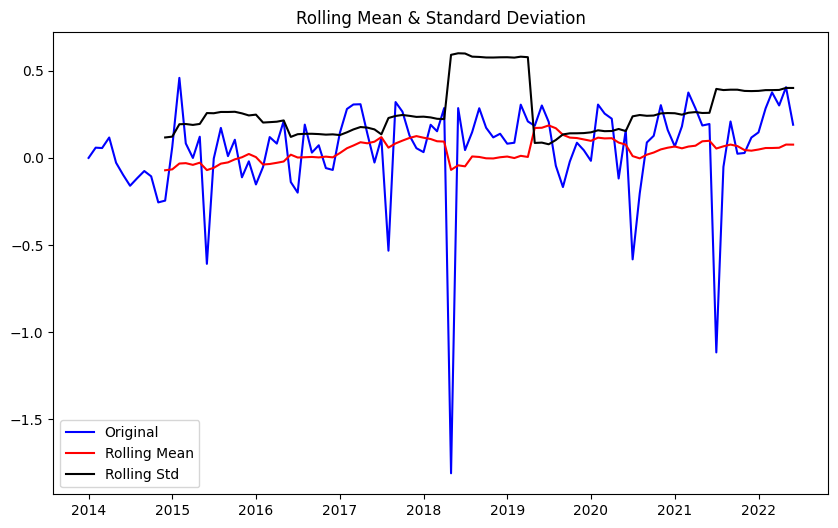

Results of Dickey-Fuller Test:
Test Statistic                -9.637914e+00
p-value                        1.548639e-16
#Lags Used                     0.000000e+00
Number of Observations Used    1.010000e+02
Critical Value (1%)           -3.496818e+00
Critical Value (5%)           -2.890611e+00
Critical Value (10%)          -2.582277e+00
dtype: float64


In [62]:
datasetLogScaleMinusMovingExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

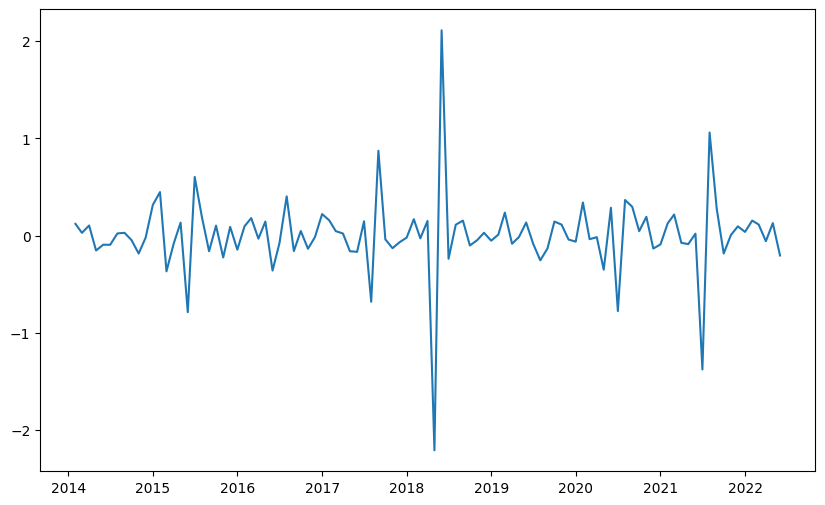

In [63]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

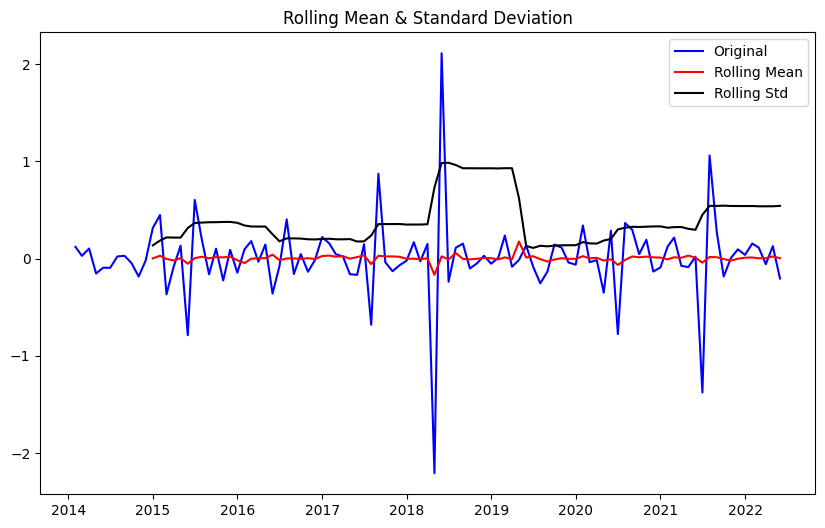

Results of Dickey-Fuller Test:
Test Statistic                -5.914413e+00
p-value                        2.593120e-07
#Lags Used                     1.000000e+01
Number of Observations Used    9.000000e+01
Critical Value (1%)           -3.505190e+00
Critical Value (5%)           -2.894232e+00
Critical Value (10%)          -2.584210e+00
dtype: float64


In [64]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

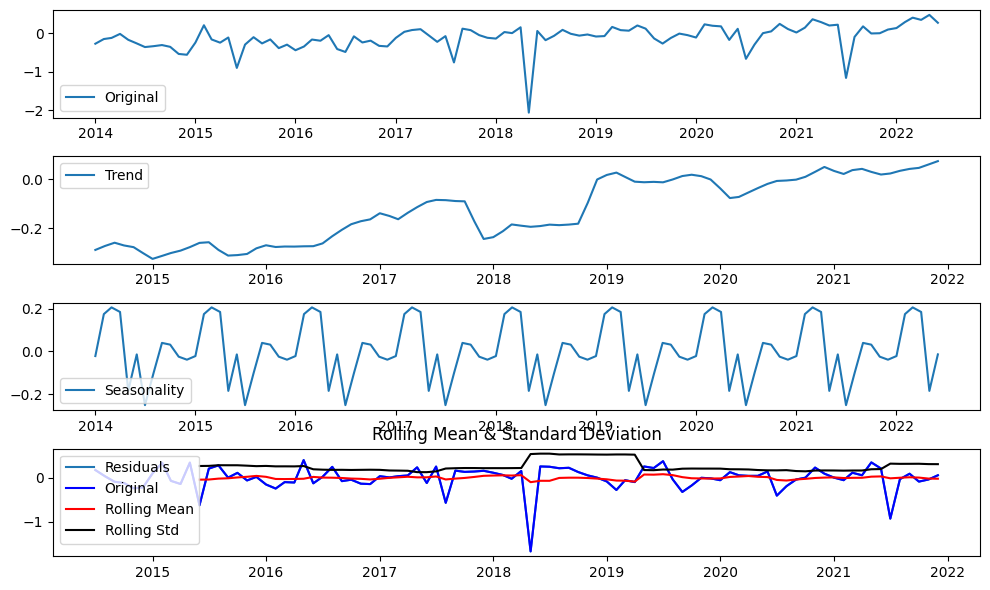

Results of Dickey-Fuller Test:
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "pandas\_libs\tslibs\parsing.pyx", line 440, in pandas._libs.tslibs.parsing.parse_datetime_string_with_reso
  File "pandas\_libs\tslibs\parsing.pyx", line 649, in pandas._libs.tslibs.parsing.dateutil_parse
ValueError: Unknown datetime string format, unable to parse: Radiance

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\Python\Lib\site-packages\pandas\core\indexes\datetimes.py", line 704, in get_loc
    parsed, reso = self._parse_with_reso(key)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Python\Lib\site-packages\pandas\core\indexes\datetimelike.py", line 230, in _parse_with_reso
    parsed, reso_str = parsing.parse_time_string(label, freq)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas\_libs\tslibs\parsing.pyx", line 367, in pandas._libs.tslibs.parsing.parse_time_string
  File "pandas\_libs\tslibs\parsing.pyx", line 445, in pandas._l

In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

decomposedLogData = residual
decomposedLogData.dropna(inplace = True)
test_stationarity(decomposedLogData)

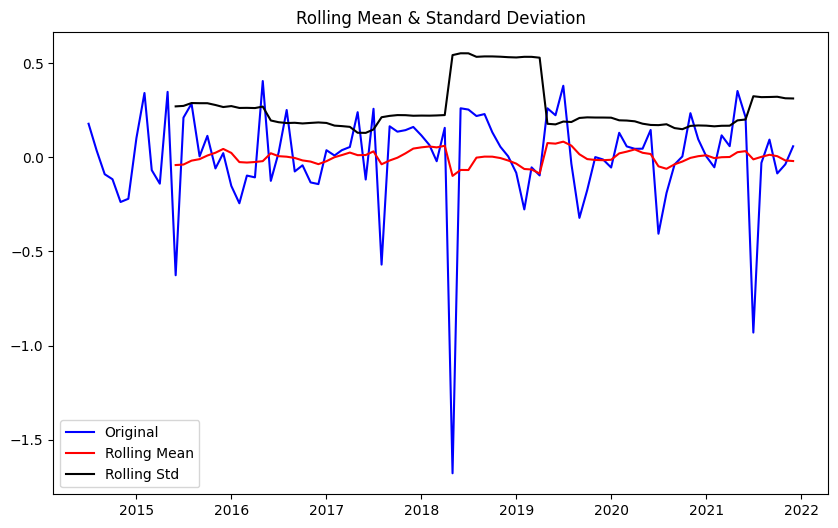

Results of Dickey-Fuller Test:
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "pandas\_libs\tslibs\parsing.pyx", line 440, in pandas._libs.tslibs.parsing.parse_datetime_string_with_reso
  File "pandas\_libs\tslibs\parsing.pyx", line 649, in pandas._libs.tslibs.parsing.dateutil_parse
ValueError: Unknown datetime string format, unable to parse: Radiance

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\Python\Lib\site-packages\pandas\core\indexes\datetimes.py", line 704, in get_loc
    parsed, reso = self._parse_with_reso(key)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Python\Lib\site-packages\pandas\core\indexes\datetimelike.py", line 230, in _parse_with_reso
    parsed, reso_str = parsing.parse_time_string(label, freq)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas\_libs\tslibs\parsing.pyx", line 367, in pandas._libs.tslibs.parsing.parse_time_string
  File "pandas\_libs\tslibs\parsing.pyx", line 445, in pandas._l

In [ ]:
decomposedLogData = residual
decomposedLogData.dropna(inplace = True)
test_stationarity(decomposedLogData)

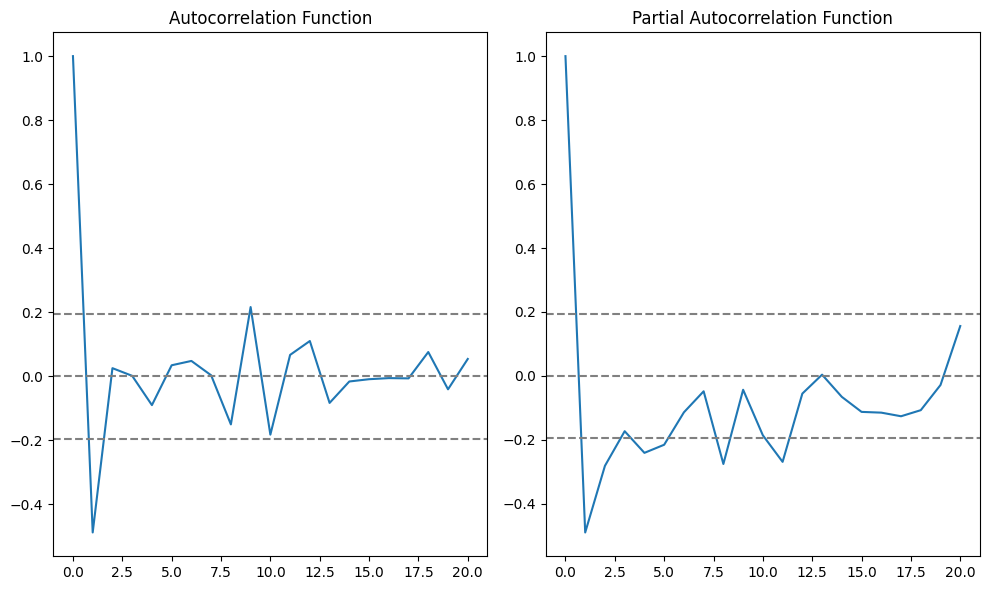

In [ ]:
# ACF and PACF plots

from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags = 20)
lag_pacf = pacf(datasetLogDiffShifting, nlags = 20, method = 'ols')

#Plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Plotting AR Model


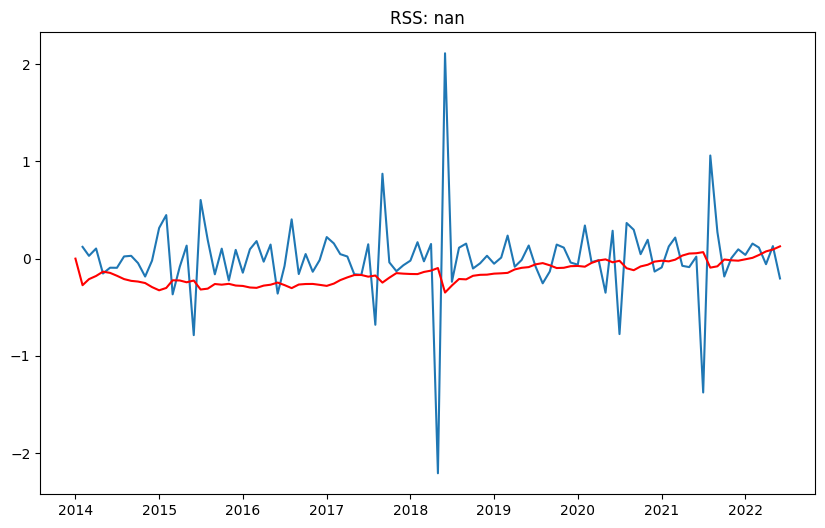

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#AR Model
model = ARIMA(indexedDataset_logScale, order = (2, 1, 2))
results_AR = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-datasetLogDiffShifting['Radiance'])**2))
print('Plotting AR Model')

d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Plotting MA Model


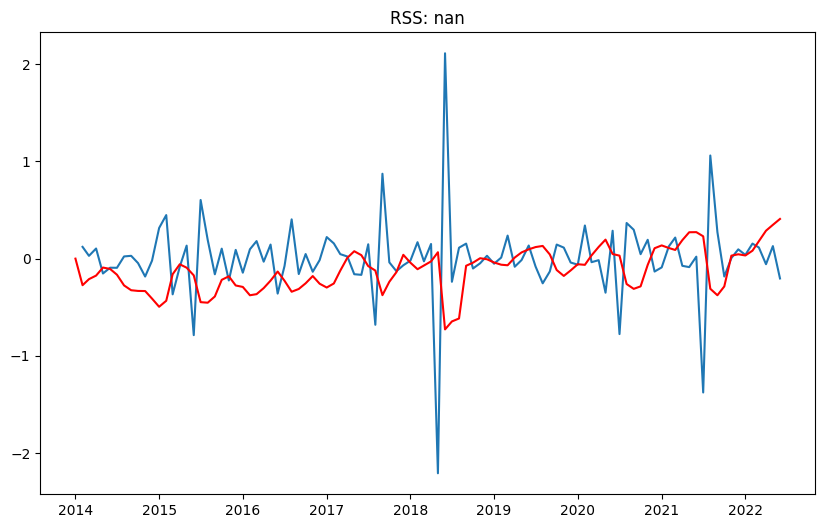

In [ ]:
#MA Model
model = ARIMA(indexedDataset_logScale, order = (2, 1, 0))
results_MA = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues - datasetLogDiffShifting['Radiance'])**2))
print('Plotting MA Model')

d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS: nan')

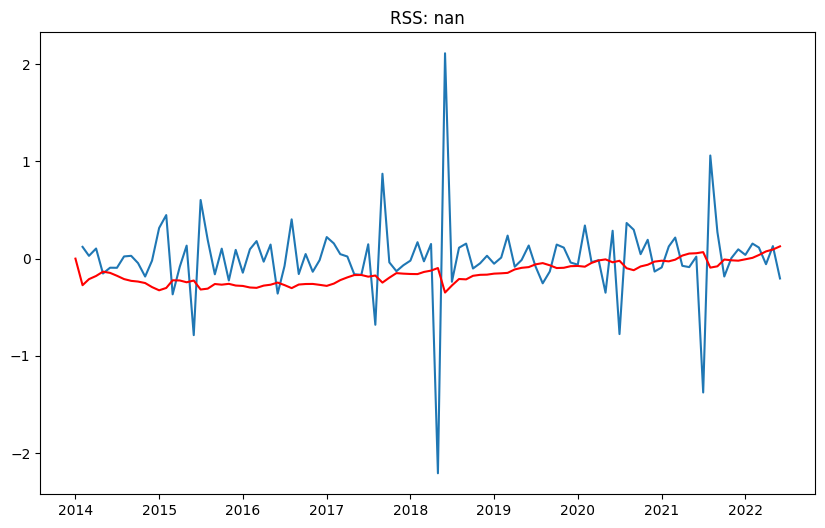

In [ ]:
model = ARIMA(indexedDataset_logScale, order = (2, 1, 2))
results_ARIMA = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['Radiance'])**2))